# Predicting Customers Ratings on Yelp

### Learnings:
1. Data Mining using Regular Expressions and APIs
2. Working with large datasets in .json format
3. Vectorization of textual data to create features for model training
4. Comparing Model Performance of Naïve Bayes Classifier, Logistic Regression Classifier, Random Forest Classifier and Linear Support Vector Machine

## Data Extraction from YELP

##### 1. Using YELP Fusion API
YELP has given developers access to download datasets using their API where-in:
- Business Search results using keywords like category, location and prices are available
- Business Details like name, address, phone number, photos, Yelp rating, price levels and hours of operation are available
- Upto 3 Customer Reviews for a business are available

- Detailed documentation which can be used to get data is [here](https://docs.developer.yelp.com/docs/fusion-intro)

##### 2. Using Existing Yelp Dataset
- For this project, I am using the already available dataset provided by [YELP](https://www.yelp.com/dataset/download)
- This 8.65GB datafile contains yelp_academic_dataset_business.json(113MB) and yelp_academic_dataset_review.json(4.97GB) which we will be using in this analysis

##### 3. Processing a HTML File
- We can also use Regular Expressions to extract data from HTML pages of the website. [Python Documentation](https://docs.python.org/3/howto/regex.html) provides more details to use 're' package

#### Below is a quick demo to extract "Top 10 Restaurants Name, Stars Received, Number of Reviews and $ Price Ratings" from a HTML webpage hosted [here](https://cse6040.gatech.edu/datasets/yelp-example)

In [1]:
#Read the html file into python string
with open('yelp.htm', 'r', encoding='utf-8') as yelp_file:
    yelp_html = yelp_file.read()

print(f'Printing first 1000 characters in the HTML file: \n\n {yelp_html[:1000]}')

Printing first 1000 characters in the HTML file: 

 <!DOCTYPE html>
<!-- saved from url=(0079)https://www.yelp.com/search?find_desc=fried+chicken&find_loc=Atlanta%2C+GA&ns=1 -->
<html xmlns:fb="http://www.facebook.com/2008/fbml" class="js gr__yelp_com" lang="en"><!--<![endif]--><head data-component-bound="true"><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"><link type="text/css" rel="stylesheet" href="./Best Fried chicken in Atlanta, GA - Yelp_files/css"><style type="text/css">.gm-style .gm-style-cc span,.gm-style .gm-style-cc a,.gm-style .gm-style-mtc div{font-size:10px}
</style><style type="text/css">@media print {  .gm-style .gmnoprint, .gmnoprint {    display:none  }}@media screen {  .gm-style .gmnoscreen, .gmnoscreen {    display:none  }}</style><style type="text/css">.gm-style-pbc{transition:opacity ease-in-out;background-color:rgba(0,0,0,0.45);text-align:center}.gm-style-pbt{font-size:22px;color:white;font-family:Roboto,Arial,sans-serif;position:relative;marg

In [2]:
# Use Regular Expressions to extract information related to Top 10 Restaurants into a list
import re
sections = re.split(r'<span class="indexed-biz-name">',yelp_html)
sections[10] = re.split(r'<a class="biz-name js-analytics-click',sections[10])[1]  #Removing the Ads section

rankings = []

pattern = r'<span>(.*)</span></a>.*(\d\.\d) star rating.* (\d+) reviews.*price-range">(\$+)'
pattern_matcher = re.compile(pattern,re.DOTALL)     #DOTALL flag enables the '.' special character match any character, including a newline

for i in range(0,len(sections)-1):
    matches = pattern_matcher.search(sections[i+1])
    rankings.append({'name':matches.groups()[0], 'stars':matches.groups()[1], 'numrevs':int(matches.groups()[2]), 'price':matches.groups()[3]})

for i, r in enumerate(rankings):
    print(f"{i+1}. {r['name']} ({r['price']}): {r['stars']} stars based on {r['numrevs']} reviews")

1. Gus’s World Famous Fried Chicken ($$): 4.0 stars based on 549 reviews
2. South City Kitchen - Midtown ($$): 4.5 stars based on 1777 reviews
3. Mary Mac’s Tea Room ($$): 4.0 stars based on 2241 reviews
4. Busy Bee Cafe ($$): 4.0 stars based on 481 reviews
5. Richards’ Southern Fried ($$): 4.0 stars based on 108 reviews
6. Greens &amp; Gravy ($$): 3.5 stars based on 93 reviews
7. Colonnade Restaurant ($$): 4.0 stars based on 350 reviews
8. South City Kitchen Buckhead ($$): 4.5 stars based on 248 reviews
9. Poor Calvin’s ($$): 4.5 stars based on 1558 reviews
10. Rock’s Chicken &amp; Fries ($): 4.0 stars based on 67 reviews


## Loading Datasets into local environment

In [3]:
import pandas as pd

In [4]:
df_business = pd.read_json('yelp_academic_dataset_business.json',lines = True) #Reading the file as a json object per line

In [5]:
print(df_business.shape)
df_business.head(2)

(150346, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [6]:
df_business = df_business[['business_id','categories']]
df_business.isna().sum()

business_id      0
categories     103
dtype: int64

In [7]:
#Removing rows with NULL categories
df_business = df_business.dropna(axis=0,subset=['categories'])
df_business.shape

(150243, 2)

In [8]:
#Filtering the data for Restaurants only to get the relevant business_ids
df_business = df_business[df_business['categories'].apply(lambda x: bool(re.search('restaurant',x.lower())))]
df_business.reset_index(drop=True, inplace=True)
df_business.shape

(52286, 2)

#### As the reviews file size is very large(~5GB), [Techniques](https://towardsdatascience.com/5-ways-to-deal-with-large-datasets-in-python-9a80786c4182) like providing data types of each column, splitting data into chunks and taking advantage of lazy evaluation are utilized.
- Post which merging the file with the Business Details dataset reduces the size further, as we want reviews for businesses with ratings present which can be utilized for model training

In [9]:
chunk_size = 1000000
chunk = pd.read_json('yelp_academic_dataset_review.json',lines = True,chunksize=chunk_size,
                                dtype={'review_id':str,'user_id':str,'business_id':str,'stars':int,'date':str,'text':str,'useful':int,
                                'funny':int,'cool':int})  #Column details are available on YELP website

In [10]:
#Merging Business data with Reviews data
chunk_list=[]
for review_temp in chunk:
    review_temp_merged = pd.merge(df_business, review_temp[['business_id','stars','text']], on='business_id', how='inner')
    print(f'Shape is {review_temp_merged.shape}')
    chunk_list.append(review_temp_merged)

df_review = pd.concat(chunk_list, ignore_index=True, join='outer', axis=0)

Shape is (689519, 4)
Shape is (677970, 4)
Shape is (669057, 4)
Shape is (667487, 4)
Shape is (672899, 4)
Shape is (690267, 4)
Shape is (657485, 4)


In [26]:
print(df_review.shape)
df_review.head(2)

(4724684, 2)


,text,stars
0,This is nice little Chinese bakery in the hear...,4
1,This is the bakery I usually go to in Chinatow...,4


In [12]:
df_review = df_review[['text','stars']]

## Data Preprocessing

##### Checking distribution of the y-variable:

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [14]:
#Checking distribution of the y-variable:
plot_ydist = df_review['stars'].value_counts()
plot_ydist.index,plot_ydist.values

(Int64Index([5, 4, 1, 3, 2], dtype='int64'),
 array([2079531, 1130305,  567227,  543126,  404495], dtype=int64))

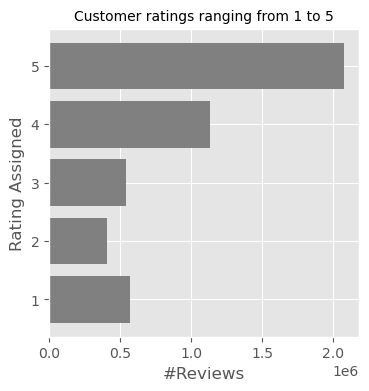

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(plot_ydist.index,width=plot_ydist.values,color='grey')
ax.set_title('Customer ratings ranging from 1 to 5',size=10)
ax.set_xlabel('#Reviews',size=12)
ax.set_ylabel('Rating Assigned',size=12)
plt.show()

##### As we have imbalanced y-variable counts, we can down-sample the classes which are large in number for model training 

In [16]:
#Creating Training, Validation and Test Datasets
from sklearn.model_selection import train_test_split

df_train_raw, df_test = train_test_split(df_review, test_size=250000, random_state= 1, shuffle=True)
df_train_raw, df_val = train_test_split(df_train_raw, test_size=250000,random_state= 1, shuffle=True)

In [17]:
print(df_train_raw.shape)
print(df_test.shape)
print(df_val.shape)

(4224684, 2)
(250000, 2)
(250000, 2)


In [18]:
df_train_raw['stars'].value_counts().sort_values(ascending=True)

2     361502
3     485519
1     507474
4    1010102
5    1860087
Name: stars, dtype: int64

In [19]:
#We can down-sample data such that each class has 250000 reviews for model training
from sklearn.utils import resample
df_train = []
for star in df_train_raw['stars'].unique():
    df_temp = df_train_raw[df_train_raw['stars'] == star]
    df_temp_undersampled = resample(df_temp, replace=False, n_samples=250000, random_state=0)
    df_train.append(df_temp_undersampled)

In [20]:
df_train = pd.concat(df_train)

In [21]:
df_train['stars'].value_counts()

4    250000
2    250000
1    250000
5    250000
3    250000
Name: stars, dtype: int64

In [22]:
df_test['stars'].value_counts(), df_val['stars'].value_counts()

(5    109639
 4     60088
 1     29827
 3     28873
 2     21573
 Name: stars, dtype: int64,
 5    109805
 4     60115
 1     29926
 3     28734
 2     21420
 Name: stars, dtype: int64)

##### Utilizing the [TF-IDF Vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) which ignores stop words and converts customer review text into features for model training

Uni-gram features considers each unique word as a feature whereas Bi-grams considers pairs of words as features.
The "TfidfVectorizer" generates a word-review matrix, where entry (i, j) is the frequency of occurence of word i in the 
j’th review. Then the TF-IDF (Term Frequency - Inverse Document Frequency) weighting technique is applied to this matrix to obtain the final feature matrix. This weighting technique assigns less weight to words that occur more frequently across reviews (e.g. “food”) because they are generally not good distinguishers between any pair of reviews,and a high weight to more rare words. Each column of this matrix is a feature vector of the corresponding review [Source](https://arxiv.org/pdf/1605.05362.pdf)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',stop_words='english',
                             ngram_range=(1, 1), #(1, 1) means only unigrams, (1, 2) means unigrams and bigrams, and (2, 2) means only bigrams
                             lowercase=True,
                             min_df=5,  #Minimum frequency for a word to be considered
                             binary=False)

X_train = vectorizer.fit_transform(df_train["text"]) #Learn vocabulary and idf, return document-term matrix
y_train = df_train["stars"].tolist()

X_val = vectorizer.transform(df_val["text"]) #Transform documents to document-term matrix.
y_val = df_val["stars"].tolist()

X_test = vectorizer.transform(df_test["text"]) #Transform documents to document-term matrix by using vocabulary and document frequencies learned by fit_transform
y_test = df_test["stars"].tolist()

In [27]:
X_train, X_test, X_val

(<1250000x62333 sparse matrix of type '<class 'numpy.float64'>'
 	with 52782527 stored elements in Compressed Sparse Row format>,
 <250000x62333 sparse matrix of type '<class 'numpy.float64'>'
 	with 9801835 stored elements in Compressed Sparse Row format>,
 <250000x62333 sparse matrix of type '<class 'numpy.float64'>'
 	with 9775131 stored elements in Compressed Sparse Row format>)

## Model Training

### Using Naïve Bayes Classifier

**Points to note while using Naïve Bayes:**
- Naïve Bayes assumes conditional independence between features given Y and therefore correlated attributes degrades its performance. 
- It can handle missing values in both training and test insances by using only the non-missing attributes while computing posterior probabilities
- It is robust to isolated noise points because such points are not able to significantly impact the conditional probability estimates
- It is robust to irrelevant attributes as if Xi is an irrelevant attribute, then P(Xi|Y) becomes almost uniformly distributed for every class y

**"Bayesian Networks"** can be used if we need to relax the rigid conditional independence assumption

Here, we are using the [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) as it is most suitable for classification with tf-idf

In [29]:
from sklearn.naive_bayes import MultinomialNB
classification_nb = MultinomialNB(fit_prior=True,#Whether to learn class prior probabilities or not.
                                 alpha=1.0) #Laplace smoothing parameter is used to avoid getting zero conditional probability 

In [30]:
%time classification_nb.fit(X_train, y_train)

Wall time: 1.28 s


MultinomialNB()

In [40]:
# Evaluation Metrics for classification models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report, plot_confusion_matrix

##### Definitions of Evaluation Metrics
**Accuracy**:- is calculated as #Correct Predictions/#Total predictions i.e. (TP+TN/TP+TN+FP+FN)  
It is recommended to not use Accuracy when we have imbalanced dataset as the correct predictions on one class would dominate the accuracy metric, even if another class having lower count has lots of incorrect predictions. Eg: Detecting Spam Emails

Following metrics are calculated for every class:  
**Precision**:- #truly positive cases out of all positive predictions i.e. (TP/TP+FP)  
Eg: During detection of spam emails, we wouldnt want to call important emails as spam, so we want to reduce FP as much as we can 

**Recall**:- #truly positive cases out of all actually positive cases i.e. (TP/TP+FN)  
Eg: During Fraudulent Bank Detections, we wouldnt want to miss any fraud transcations, so we want to reduce FN as much as we can 

**F1 Score**:- Harmonic mean of precision and recall, taking into account both FP and FN can be used on imbalanced datasets

In [36]:
import numpy as np
def Model_Evaluation(model,X_train,y_train,X_test,y_test,X_val,y_val):
    print('For Training Dataset:\n')
    y_pred_train = model.predict(X_train)
    print("Accuracy:", np.round(accuracy_score(y_train, y_pred_train),2))
    print(classification_report(y_train, y_pred_train))
    #fig, ax = plt.subplots(figsize=(4, 4))
    #plot_confusion_matrix(model, X_train, y_train, cmap=plt.cm.Blues,values_format= '.0%', normalize='true',ax=ax)
    
    print('########################################################################')
    print('For Validation Dataset:\n')
    y_pred_val = model.predict(X_val)
    print("Accuracy:", np.round(accuracy_score(y_val, y_pred_val),2))
    print(classification_report(y_val, y_pred_val))
    print('########################################################################')
    print('For Testing Dataset:\n')
    y_pred_test = model.predict(X_test)
    print("Accuracy:", np.round(accuracy_score(y_test, y_pred_test),2))
    print(classification_report(y_test, y_pred_test))

In [37]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
Model_Evaluation(classification_nb,X_train,y_train,X_test,y_test,X_val,y_val)

For Training Dataset:

Accuracy: 0.58
              precision    recall  f1-score   support

           1       0.63      0.71      0.67    250000
           2       0.49      0.45      0.47    250000
           3       0.50      0.48      0.49    250000
           4       0.53      0.54      0.53    250000
           5       0.70      0.71      0.70    250000

    accuracy                           0.58   1250000
   macro avg       0.57      0.58      0.57   1250000
weighted avg       0.57      0.58      0.57   1250000

########################################################################
For Validation Dataset:

Accuracy: 0.59
              precision    recall  f1-score   support

           1       0.62      0.69      0.65     29926
           2       0.35      0.42      0.38     21420
           3       0.37      0.44      0.40     28734
           4       0.47      0.50      0.49     60115
           5       0.81      0.69      0.74    109805

    accuracy                      

### Using Logistic Regression Classifier

**Points to note while using Logistic Regression:**
- Logistic Regression directly computes posterior probabilities without computing class conditional probabilities
- It can learn only linear decision boundaries, but can be extended to multiclass classification by training multiple models to learn each of the class labels individually
- It cannot handle missing values as posterior probabilites are calculated by taking a weighted sum of all attributes. Training instance with missing value have to be discarded, however if there are missing value in test data then logistic regression fails to predict its class label 
- It can handle irrelevant attributes by learning weight parameters close to zero for attributes that do not provide any gain in performance during model training. It can also handle interacting attributes since the learning of model parameters is achieved in a joint fashion by considering the effects of all attributes together.

**Assumptions:**
- There is a linear relationship between explanatory variables and the Logit of the Response Variable
- Observations in the dataset are independent of each other
- There is no multicollinearity among explanatory variables
- There are no extreme outliers

In [35]:
from sklearn.linear_model import LogisticRegression

[Documentation for sklearn's Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [36]:
classification_logr = LogisticRegression(penalty='l2', #default is l2 penalty
                            tol=1e-4, #Tolerance for stopping criteria
                            C=5.0,
                            fit_intercept=True,
                            class_weight='balanced',
                            random_state=0,
                            solver='lbfgs',
                            max_iter=100,
                            multi_class='auto',
                            verbose=1,
                            n_jobs=-1)

In [37]:
%time classification_logr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.3min finished


Wall time: 3min 17s


LogisticRegression(C=5.0, class_weight='balanced', n_jobs=-1, random_state=0,
                   verbose=1)

In [38]:
Model_Evaluation(classification_logr,X_train,y_train,X_test,y_test,X_val,y_val)

For Training Dataset:

Accuracy: 0.61
              precision    recall  f1-score   support

           1       0.71      0.75      0.73    250000
           2       0.54      0.52      0.53    250000
           3       0.54      0.50      0.52    250000
           4       0.55      0.54      0.54    250000
           5       0.70      0.74      0.72    250000

    accuracy                           0.61   1250000
   macro avg       0.60      0.61      0.61   1250000
weighted avg       0.60      0.61      0.61   1250000

########################################################################
For Validation Dataset:

Accuracy: 0.63
              precision    recall  f1-score   support

           1       0.72      0.74      0.73     29926
           2       0.42      0.51      0.46     21420
           3       0.42      0.49      0.45     28734
           4       0.50      0.52      0.51     60115
           5       0.82      0.73      0.77    109805

    accuracy                      

### Using Random Forest Classifier

**Points to note while using Random Forest:**
- Random Forest is a bagging algorithm where-in different subsets of size N (same as entire training data) generated by random sampling with replacement of the training data, result in different trees
- One variation from a standard bagging algorithm is that random forest also uses feature randomness wherein each tree in a random forest can pick only from a random subset of features
- Bagging and Feature Randomness are applied when building each individual tree (which are not pruned), which create an uncorrelated forest of trees whose prediction by committee is more accurate than any individual tree

**Decision Tree**
- Decision Trees uses a greedy approach to grow by making locally optimal decisions about which attribute to use when partitioning the training data
- Entropy or Gini Index or Gain Ratio which takes into account the number of branches into which tree splits is used for splitting the data
- Decision Trees are a non-parametric approach which does not require any prior assumptions about the probability distribution of the attributes and also doesnt require any data transformations
- It cannot handle interacting variables(if they are able to distinguish between classes when used together, but individually they provide little or no information) and performs poorly due to the greedy nature of splitting criteria as such variables might be passed over 
- It can handle missing values, irrelevant attributes (which are not useful for the classification task) by passing over them as they will not provide gain in purity and redundant attributes (if it is strongly correlated with another attribute in the data) as only one of them will be selected as they provide similar gains in purity
- It can only learn linear decision boundaries - typically parallel to axis(x1<10 or x2>5), it can learn oblique decision boundaries(x1+x2<10) but they are computationally more expensive

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [46]:
classification_rf = RandomForestClassifier(n_estimators=50, #Number of Trees
                                criterion="gini",
                                max_depth=10, #Max Depth of Trees
                                min_samples_split=2,
                                min_samples_leaf=10, 
                                max_features=0.5, #Use half random features 
                                n_jobs=-1,
                                verbose=1,
                                random_state=0,
                                class_weight='balanced')

In [47]:
%time classification_rf.fit(X_train, y_train) 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed: 28.3min


Wall time: 46min 26s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 46.4min finished


RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=0.5,
                       min_samples_leaf=10, n_estimators=50, n_jobs=-1,
                       random_state=0, verbose=1)

In [48]:
Model_Evaluation(classification_logr,X_train,y_train,X_test,y_test,X_val,y_val)

For Training Dataset:

Accuracy: 0.61
              precision    recall  f1-score   support

           1       0.71      0.75      0.73    250000
           2       0.54      0.52      0.53    250000
           3       0.54      0.50      0.52    250000
           4       0.55      0.54      0.54    250000
           5       0.70      0.74      0.72    250000

    accuracy                           0.61   1250000
   macro avg       0.60      0.61      0.61   1250000
weighted avg       0.60      0.61      0.61   1250000

########################################################################
For Validation Dataset:

Accuracy: 0.63
              precision    recall  f1-score   support

           1       0.72      0.74      0.73     29926
           2       0.42      0.51      0.46     21420
           3       0.42      0.49      0.45     28734
           4       0.50      0.52      0.51     60115
           5       0.82      0.73      0.77    109805

    accuracy                      

### Using Linear Support Vector Machine

**Points to note while using Support Vector Machine:**
- SVM learning is formulated as a convex optimization problem, wherein we can find the global minima whereas greedy algorithms like tree and neural networks tend to find locally optimal solutions
- SVM provides an effective way of regularizing the model parameters by maximizing the margin of the decision boundary. It is able to create a balance between model complexity and training errors by using a hyper-parameter 'alpha' in sk-learn
- It can handle irrelevant attributes by learning zero weights for such attributes. It can also handle redundant attributes by learning similar weights for the duplicate attributes.
- It cant handle missing data and data imputation is to be performed

In [54]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

classification_cvm = make_pipeline(StandardScaler(with_mean=False),
                    SGDClassifier(loss = 'hinge',  #For using linear SVM
                                  max_iter=1000, 
                                  penalty = 'l2',
                                  tol=1e-3,
                                  alpha = 0.1, #Constant that multiplies the regularization term. The higher the value, the stronger the regularization
                                  verbose = 1,
                                  random_state = 1,
                                  class_weight = 'balanced',
                                  early_stopping = True))

In [55]:
%time classification_cvm.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 1.00, NNZs: 57078, Bias: -0.070079, T: 1125000, Avg. loss: 0.364117
Total training time: 0.33 seconds.
-- Epoch 2
Norm: 0.84, NNZs: 58869, Bias: -0.070849, T: 2250000, Avg. loss: 0.246257
Total training time: 0.79 seconds.
-- Epoch 3
Norm: 0.79, NNZs: 59374, Bias: -0.071314, T: 3375000, Avg. loss: 0.234223
Total training time: 1.24 seconds.
-- Epoch 4
Norm: 0.77, NNZs: 59595, Bias: -0.071646, T: 4500000, Avg. loss: 0.228984
Total training time: 1.70 seconds.
-- Epoch 5
Norm: 0.76, NNZs: 59691, Bias: -0.071903, T: 5625000, Avg. loss: 0.225936
Total training time: 2.16 seconds.
-- Epoch 6
Norm: 0.76, NNZs: 59738, Bias: -0.072112, T: 6750000, Avg. loss: 0.223928
Total training time: 2.63 seconds.
Convergence after 6 epochs took 2.78 seconds
-- Epoch 1
Norm: 0.88, NNZs: 60440, Bias: -0.089381, T: 1125000, Avg. loss: 0.597024
Total training time: 0.31 seconds.
-- Epoch 2
Norm: 0.65, NNZs: 61444, Bias: -0.091461, T: 2250000, Avg. loss: 0.412295
Total training time: 0.78 seco

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.8s finished


Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('sgdclassifier',
                 SGDClassifier(alpha=0.1, class_weight='balanced',
                               early_stopping=True, random_state=1,
                               verbose=1))])

In [56]:
Model_Evaluation(classification_cvm,X_train,y_train,X_test,y_test,X_val,y_val)

For Training Dataset:

Accuracy: 0.62
              precision    recall  f1-score   support

           1       0.65      0.84      0.73    250000
           2       0.58      0.45      0.51    250000
           3       0.58      0.46      0.52    250000
           4       0.58      0.48      0.53    250000
           5       0.65      0.84      0.73    250000

    accuracy                           0.62   1250000
   macro avg       0.61      0.62      0.60   1250000
weighted avg       0.61      0.62      0.60   1250000

########################################################################
For Validation Dataset:

Accuracy: 0.62
              precision    recall  f1-score   support

           1       0.63      0.80      0.71     29926
           2       0.37      0.38      0.37     21420
           3       0.39      0.39      0.39     28734
           4       0.50      0.40      0.45     60115
           5       0.77      0.79      0.78    109805

    accuracy                      